### <font color='red'>Quora Question Pairs</font>

### Import required libraries

In [1]:
import pandas as pd
import itertools as itertools
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer, confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Merge, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from nltk.corpus import stopwords

import re
import Levenshtein as leven
from gensim.models import KeyedVectors
from math import sqrt

Using TensorFlow backend.


In [2]:
# for reproducability
np.random.seed(1234)

### Import datasets and clean data, for practice.
The training dataset provided will be split into train-test to validate model's accuracy

In [3]:
## edit the link to be shorter and accessible from root folder
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
embedding_file = "./GoogleNews-vectors-negative300.bin.gz"

## Exploratory Data Analysis (EDA)

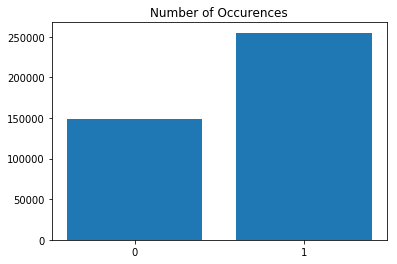

Number of duplicates in the training dataset: 149263
Number of non-duplicates in the training dataset: 255027
Percentage of duplicates in training dataset: 0.0%
Percentage of non-duplicates in training dataset: 100.0%


In [4]:
count_dups = np.sum(train.iloc[:,-1] == 1)
# positive classes' percentage in the training dataset
positive_dups = round(count_dups/train.shape[0]*100, 2)

%matplotlib inline
x = ["duplicates", "non-duplicates"]
plt.bar(x, [count_dups, train.shape[0] - count_dups], align='center')
plt.title('Number of Occurences')
plt.xticks(x, range(len(x)))
plt.yticks()
plt.show()

print("Number of duplicates in the training dataset: {}".format(count_dups))
print("Number of non-duplicates in the training dataset: {}".format(train.shape[0] - count_dups))
print("Percentage of duplicates in training dataset: {}%".format(positive_dups))
print("Percentage of non-duplicates in training dataset: {}%".format(100.0 - positive_dups))

In [5]:
## summary statistics
train.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
train.info()

test.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      2345796 non-null int64
question1    2345794 non-null object
question2    2345792 non-null object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [7]:
train[train.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
test[test.isnull().any(axis=1)]

,test_id,question1,question2
379205,379205,How I can learn android app development?,NaN
817520,817520,How real can learn android app development?,NaN
943911,943911,How app development?,NaN
1046690,1046690,NaN,How I what can learn android app development?
1270024,1270024,How I can learn app development?,NaN
1461432,1461432,NaN,How distinct can learn android app development?


For the training dataset, there are 2 null values under feature 'question2' and 1 under feature 'question1'.

For the testing dataset, we have 2 null values under feature 'question1' and 4 under feature 'question2'.

#### We drop the rows with null values in the questions columns and double check to confirm if it is removed.

In [9]:
train = train.fillna("")
test  = test.fillna("")

# Verify that rows with null values have been removed
train.info()
test.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      2345796 non-null int64
question1    2345796 non-null object
question2    2345796 non-null object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


### Metrics

17% duplicates are in the test set (as discussed aplenty below):
- https://swarbrickjones.wordpress.com/2017/03/28/cross-entropy-and-training-test-class-imbalance/
- https://www.kaggle.com/davidthaler/how-many-1-s-are-in-the-public-lb/comments
- https://www.kaggle.com/c/quora-question-pairs/discussion/31179

Therefore, we try to emulate the same split (17% duplicates, 83% non-duplicates) by rescaling their predictions by the same factor against the training dataset's split (63-37).

In [10]:
## accounting for the discrepancy of the class breakdown of training and testing data
def weighted_log_loss(y_true, y_pred):
    a = 0.165/0.37
    b = (1-0.165)/(1-0.37)
    score = a*y_true*np.log(y_pred+0.00001) + b*(1.0 - y_true)*np.log(1.0 - y_pred+0.00001)
    return -np.mean(score)

## Data Preprocessing and Modelling

In [11]:
# separate labels and data
train_X, train_y = train.iloc[:,:-1], train.iloc[:,-1]
test_X = test

### Random Forests Classifier
### Classical features

In [12]:
def words(qn):
    """
    Returns the number of words in a question
    """
    return len(qn.split())

def avg_word_length(qn):
    """
    Tabulates the average word length in a question
    """
    words = qn.split()
    return sum([len(word) for word in words])/len(words) if len(words) != 0 else 0

def char_count(qn):
    """
    Counts the total number of letters in a question
    """
    return sum([len(word) for word in qn.split()])

def caps_count(qn):
    """
    Counts the number of capital letters in a question, 
    only checking the first word of each sentence
    """
    words = qn.split()
    return sum([1 for word in words if word[0].isupper()])

# Jaccard Similiarity Coefficient
# Obtain the Jaccard Similiarity Coeefficient between 2 questions
# (X intersect Y) / (X union Y)
# Bag Of Words, which is the list of unique words in the document, with no frequency count.
def jaccard_index(row):
    """
    Obtain the Jaccard Similarity Coefficient which essentially is represented
    by: (X intersect Y) / (X union Y). Done using the Bag Of Words, 
    which is the list of unique words in the document, with no frequency count involved. 
    
    Input
    ------
    row: the row with both questions 1 and 2.
    
    Returns
    -------
    index: the Jaccard index (AKA Similarity Coefficient)
    """
    q1 = set(row['question1'].split())
    q2 = set(row['question2'].split())
    index = 1.0
    index = (float(len(q1.intersection(q2))) 
             / len(q1.union(q2)))
    return index
    

def levenshtein(dataframe):
    """
    Obtain the Levensthein distance between the two questions.
    Levensthein distance is another similarity index like Jaccard. 
    """
    return leven.distance(dataframe['question1'], dataframe['question2'])

In [13]:
def feature_engineering_classic(df, which):
    if which == "train":
        qns_set = df.iloc[:,3:5] 
        q1 = qns_set.iloc[:,0]
        q2 = qns_set.iloc[:,1]
    elif which == "test":
        qns_set = df.iloc[:,1:]
        q1 = df.iloc[:,1]
        q2 = df.iloc[:,2]    

    # Creating new features using Feature Engineering
    word_len_diff = abs(q1.apply(words) - q2.apply(words))
    avg_word_len_diff = abs(q1.apply(avg_word_length) - q2.apply(avg_word_length))
    char_diff = abs(q1.apply(char_count) - q2.apply(char_count))
    caps_diff = abs(q1.apply(caps_count) - q2.apply(caps_count))
    jaccard = qns_set.apply(jaccard_index, axis=1)
    leven_dist = qns_set.apply(levenshtein, axis=1)

    # Creating a new dataframe with values of new feature
    classic_feat = pd.DataFrame({'word_len_diff': word_len_diff, 'avg_word_len_diff': avg_word_len_diff, 
                                 'char_diff': char_diff, 'caps_diff': caps_diff, 'jaccard': jaccard, 
                                 'leven_dist': leven_dist})
    return classic_feat

# classic features for Random Forests classifier
classic_train_X = feature_engineering_classic(train_X, "train")
classic_test_X = feature_engineering_classic(test_X, "test")

In [14]:
# Cross validation with Grid Search to optimize hyper parameters
cv_sets = KFold(n_splits=10, random_state=0)
scorer = make_scorer(weighted_log_loss, greater_is_better=False)

# varying class_weight to penalize False Positives more 
grid = GridSearchCV(RandomForestClassifier(200, random_state=0),
                        scoring=scorer,
                        cv = cv_sets,
                        param_grid={"class_weight": [{0:100, 1:1}, {0:10, 1:1}, {0:1, 1:1}]})

# Training Random Forest Classifier with full training dataset
grid.fit(classic_train_X, train_y)
print("Random Forests Classifier log loss error: {}".format(grid.best_score_))

Random Forests Classifier log loss error: -2.81428114447


In [15]:
# generate predictions and submit on kaggle
# prob_y = grid.predict_proba(classic_test_X)

# submission = pd.DataFrame()
# submission['test_id'] = test_X['test_id']
# submission['is_duplicate'] = prob_y[:,1]
# submission.to_csv("submission_rf.csv", index=False)

### Results for benchmark RandomForestClassifier 
Unfortunately the benchmark scores were not very satisfactory - achieving scores of 0.59123 & 0.58364 on the private and public leaderboard respectively.. Let's attempt the deep learning model (LSTM) and the new and interesting features in the Google corpus' pre-trained embeddings.

## Siamese LSTM-word embedding model

### Further Improvements:
Pre-Processing word2vec. Derived from Elior Cohen's data cleaning process and building the embedding matrix. Further data cleaning through stopwords to enhance data quality to achieve a better model

In [16]:
def text2word(text):
    text = str(text).lower()

    # Text cleaning
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = text.split()
    return text

### Run once ONLY to download stopwords' corpus

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zhenxuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Prepare vocabulary of words to be assigned to pre-trained Google corpus' weights

In [18]:
# Prepare vocabulary and look up list
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # placeholder for the [0, 0, ....0] embedding / padding
word2vec = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
stops = set(stopwords.words("english"))

questions_cols = ['question1', 'question2']

# Iterate over the questions only of the training dataset
for dataset in [train_X, test_X]:
    for index, row in dataset.iterrows():
        # Iterate through the text of both questions of the row
        for question in questions_cols:
            q2n = []  # q2n -> question to numbers representation
            for word in text2word(row[question]):
                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue
                # add new word into vocabulary and assign look up tables with both word & number
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions with number representations from vocabulary look-up table
            dataset.set_value(index, question, q2n)

embedding_dim = 300
# This will be the embedding matrix, generated from gaussian distribution for words that do not appear at all. (default values)
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  
embeddings[0] = 0  # So that the padding will be ignored

/home/zhenxuan/anaconda3/envs/udacity/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [19]:
# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        # adds in the embedding dimension's values per row from Google's pre-trained model
        embeddings[index] = word2vec.word_vec(word)

del word2vec # to not clog up memory on the system

#### Train-Validation data split for x and y values and zero padding of values to ensure consistency in the shape of the data
We do a train-validation dataset split so we can have the hold-out test set to be experimented on to improve on our classification model. By including validation data as a "holdout dataset" allows me to justify our model's usefulness and effectiveness, due to Kaggle's test set being justified in terms of leaderboard rankings/LB score.

In [20]:
# To obtain the max length of the longest question in train/test datasets
max_seq_length = max(train_X.question1.map(lambda x: len(x)).max(),
                     train_X.question2.map(lambda x: len(x)).max(),
                     test_X.question1.map(lambda x: len(x)).max(),
                     test_X.question2.map(lambda x: len(x)).max())

In [21]:
LSTM_train_X, LSTM_valid_X, LSTM_train_y, LSTM_valid_y = train_test_split(train_X, train_y, test_size=0.2)

# Split to dictionaries for training, validation and test data
LSTM_train_X = {'left': LSTM_train_X.question1, 'right': LSTM_train_X.question2}
LSTM_valid_X = {'left': LSTM_valid_X.question1, 'right': LSTM_valid_X.question2}
LSTM_test_X = {'left': test_X.question1, 'right': test_X.question2}

# Convert y-values (labels) to their numpy representations
LSTM_train_y = LSTM_train_y.values
LSTM_valid_y = LSTM_valid_y.values

# Zero padding
for dataset, side in itertools.product([LSTM_train_X, LSTM_valid_X], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Checking consistent shapes for data using assert
assert LSTM_train_X['left'].shape == LSTM_train_X['right'].shape # left and right columns are of the same length
assert len(LSTM_train_X['left']) == len(LSTM_train_y) # check if number of rows tally

### LSTM model building and training

In [22]:
def weighted_log_loss(y_true, y_pred):
    a = 0.165/0.37
    b = (1-0.165)/(1-0.37)
    score = a*y_true*K.log(y_pred+0.00001) + b*(1.0 - y_true)*K.log(1.0 - y_pred+0.00001)
    return -K.mean(score)

In [23]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [26]:
# Model hyperparameters
hidden_layer_nodes = 50
batch_size = 128
epochs = 10

# declare left and right inputs
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

# Create an embedding layer to convert words to their embeddings
embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Convert inputs into word embeddings
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# lstm layer that will return an output the size of the number of hidden layer nodes
shared_lstm = LSTM(hidden_layer_nodes)

# run both inputs through shared lstm
output_left = shared_lstm(encoded_left)
output_right = shared_lstm(encoded_right)

# concatenate results of both encoded vectors
merged_vector = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))\
                ([output_left, output_right])

# finish off model with output layer
maLSTM = Model([left_input, right_input], [merged_vector])

# optimizer
optimizer = Adam(clipnorm=.9)

# complete model
maLSTM.compile(optimizer=optimizer, loss=weighted_log_loss, metrics=['accuracy'])

# summarize the model
print(maLSTM.summary())

# Start training
model_trained = maLSTM.fit([LSTM_train_X['left'], LSTM_train_X['right']], LSTM_train_y, batch_size=batch_size, epochs=epochs,
                            validation_data=([LSTM_valid_X['left'], LSTM_valid_X['right']], LSTM_valid_y), verbose=1)

/home/zhenxuan/anaconda3/envs/udacity/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 213)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 213)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 213, 300)     36427800    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 50)           70200       embedding_2[0][0]                
          

### Evaluate model's holdout test loss and accuracy

In [31]:
test_loss_accuracy = maLSTM.evaluate([LSTM_valid_X['left'], LSTM_valid_X['right']], LSTM_valid_y)
print('Scalar test loss: ' + str(test_loss_accuracy[0]) + '\nModel accuracy: ' + str(test_loss_accuracy[1]))

80858/80858 [==============================] - 233s 3ms/step
Scalar test loss: 0.290278734785
Model accuracy: 0.757822355237


In [36]:
# from keras.models import load_model
# maLSTM.save('model.h5')
# maLSTM = load_model('mode.h5')

In [42]:
LSTM_test_X['left'] = pad_sequences(LSTM_test_X['left'], maxlen=max_seq_length)
LSTM_test_X['right'] = pad_sequences(LSTM_test_X['right'], maxlen=max_seq_length)
prob_y = maLSTM.predict([LSTM_test_X['left'], LSTM_test_X['right']])

## dump into .csv for Kaggle submission
submission = pd.DataFrame()
submission['test_id'] = test_X['test_id']
submission['is_duplicate'] = prob_y
submission.to_csv("submission_siameseLSTM.csv", index=False)

### Conclusion


A marked improvement was observed with the subsequent submission on Kaggle, obtaining a public and private score of 0.34697 & 0.35206 respectively. On the private leaderboard that would have meant that I would have been placed in the 1,448th place among 3,308 particpants (top 45% percentile!).